## №4

Consider the model in Eq. (1) with stationary but unknown $\sigma$ and $\rho$ and constant velocity, $u\equiv 1$. You are given a series of $T$ observations $z_1,...,z_T$ in `10_4.pickle` [pickled dict of $z_t$]. Your task is to estimate the parameters $\sigma$ and $\rho$ using maximization of the log-likelihood function.

$$
x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1},\quad z_{t}=x_{t} + \eta_{t}
\tag{1}
$$

In [1]:
using PyCall

py"""
import pickle
 
def load_pickle(fpath):
    with open(fpath, "rb") as f:
        data = pickle.load(f)
    return data
"""

data = py"load_pickle"("10_4.pickle")

Dict{Any, Any} with 1 entry:
  "z" => [5.39284, -1.77403, 11.1575, 16.8689, 19.8665, 12.0294, 14.981, 15.17,…

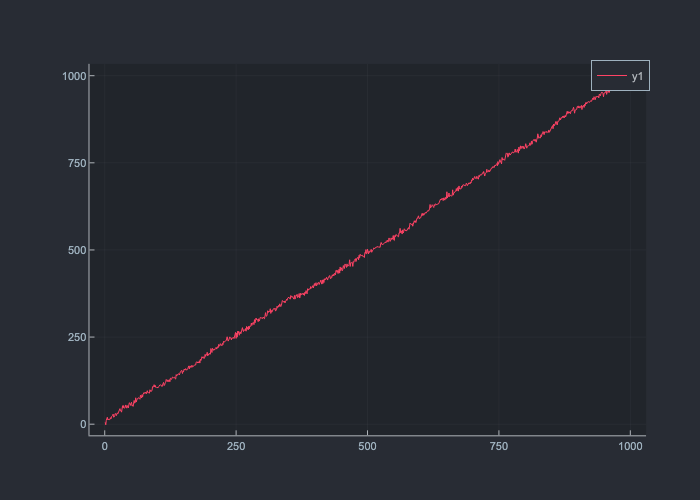

In [22]:
using Plots
plotlyjs()
theme(:juno)

z = data["z"]
plot(z)

Прежде чем мы начнем, сделаем догадку о значениях $\rho$ и $\sigma$. Заметим, что
$$
z_t - z_{t-1} \sim \mathcal{N}(u, \sigma^2 + 2\rho^2)
$$

Если дпополнительно предположить, что $\sigma \approx \rho$, то получится следующая оценка по порядку величины:

In [118]:
using Statistics: cov

initial_guess = √(cov(diff(z)) / 3)

3.357197786799682

### Task

The likelihood of given values of $\sigma$ and $\rho$ is proportional to $P(\sigma,\rho)\propto \int P(x, z, \sigma, \rho) dx$, where the integral can be evaluated explicitly. Using `JAX`, write fast code to compute $\ln P(\sigma,\rho)$ and its gradients up to the 2nd order. Perform numerical maximization to find the optimize values for $\sigma$ and $\rho$.

### Решение

Совместное распределение вероятностей равно
$$
\begin{aligned}
P & = \prod_{t=1}^{T-1}
\frac{1}{\sqrt{2 \pi} \sigma}
\exp\biggl(-\frac{(x_t - x_{t-1} - u)^2}{2\sigma^2}\biggr)
\prod_{t=0}^{T-1}
\frac{1}{\sqrt{2 \pi} \rho}
\exp\biggl(-\frac{(z_t - x_t)^2}{2\rho^2}\biggr) \\
& = \frac{1}{(2 \pi)^{T-1/2}}\frac{1}{\sigma^{T-1} \rho^T}
\exp\biggl(-\frac12 x^T Q x + x^T b \biggr)
\exp\biggl(-\frac{U}{2\sigma^2} - \frac{Z}{2\rho^2}\biggr)
\end{aligned}
$$

где:
$$
Q = \begin{pmatrix}
\frac{1}{\sigma^2} + \frac{1}{\rho^2} & -\frac{1}{\sigma^2} & 0 & \cdots & 0 \\
-\frac{1}{\sigma^2} & \frac{2}{\sigma^2} + \frac{1}{\rho^2} & -\frac{1}{\sigma^2} & \cdots & 0 \\
0 & -\frac{1}{\sigma^2} & \frac{2}{\sigma^2} + \frac{1}{\rho^2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \frac{1}{\sigma^2} + \frac{1}{\rho^2}
\end{pmatrix}
\qquad
b =
\begin{pmatrix}
\frac{0 - u_0}{\sigma^2} + \frac{z_0}{\rho^2} \\
\frac{u_0 - u_1}{\sigma^2} + \frac{z_1}{\rho^2} \\
\frac{u_1 - u_2}{\sigma^2} + \frac{z_2}{\rho^2} \\
\vdots \\
\frac{u_{T-2}}{\sigma^2} + \frac{z_{T-1}}{\rho^2}
\end{pmatrix}
$$

$$
U = \sum_{t=1}^{T-1} u^2 = (T-1) u^2
\qquad
Z = \sum_{t=0}^{T-1} z_t^2
$$

Интеграл $\int P dx$ — гауссовский, его можно вычислить по готовой формуле:
$$
\begin{aligned}
L(\sigma, \rho) = \int P dx
& =
\frac{1}{(2 \pi)^{(T-1)/2}}\frac{1}{\sigma^{T-1} \rho^T} \frac{1}{\sqrt{\det Q}}
\exp\biggl(\frac12 b^T Q^{-1} b \biggr)
\exp\biggl(-\frac{U}{2\sigma^2} - \frac{Z}{2\rho^2}\biggr)
\end{aligned}
$$

Вычислим логарифм правдоподобия:
$$
\ln L = -(T-1) \ln\sigma - T \ln \rho - \frac12 \ln \det Q + \frac12 b^T Q^{-1} b -\frac{U}{2\sigma^2} - \frac{Z}{2\rho^2} + \text{const}
$$
Введём переменные $s = \sigma^{-2}$ и $r = \rho^{-2}$. Тогда
$$
2 \ln L = (T-1) \ln s + T \ln r - \ln \det Q + b^T Q^{-1} b - Us- Zr + \text{const}
$$

Выражения для $Q$ и $b$ тоже окажутся чуть проще.

In [102]:
using LinearAlgebra

function Q_and_b(s, r, z::Vector)
    subdiagonal = -s * ones(length(z) - 1)

    main_diagonal = (2s + r) * ones(length(z))
    main_diagonal[1] = s + r
    main_diagonal[end] = s + r

    Q = SymTridiagonal(main_diagonal, subdiagonal)

    b = z * r
    b[1] -= s
    b[end] += s

    return Q, b
end

Q_and_b (generic function with 1 method)

Я использую Julia, поскольку там, в отличие от `JAX`, есть оптимизированные функции `logdet` и `\` для работы с симметричными трехдиагональными матрицами.

Это должно сократить сложность вычисления $\ln L$ c $O(T^3)$ до $O(T)$, где $T$ — число точек.

In [103]:
using LinearAlgebra

function log_likelihood_times2(σ, ρ, z::Vector)
    s = σ^-2
    r = ρ^-2
    T = length(z)

    Q, b = Q_and_b(s, r, z)

    Z = sum(z.^2)
    U = T-1

    return T * log(r) + (T-1) * log(s) - logdet(Q) + dot(b, Q \ b) - U * s - Z * r
end

log_likelihood_times2 (generic function with 1 method)

Построим функцию, которую собираемся максимизировать и убедимся, что у неё есть максимум.

Максимумов оказывается 4, поскольку функция правдоподобия не меняется при замене $\sigma \to -\sigma$ и $\rho \to -\rho$.

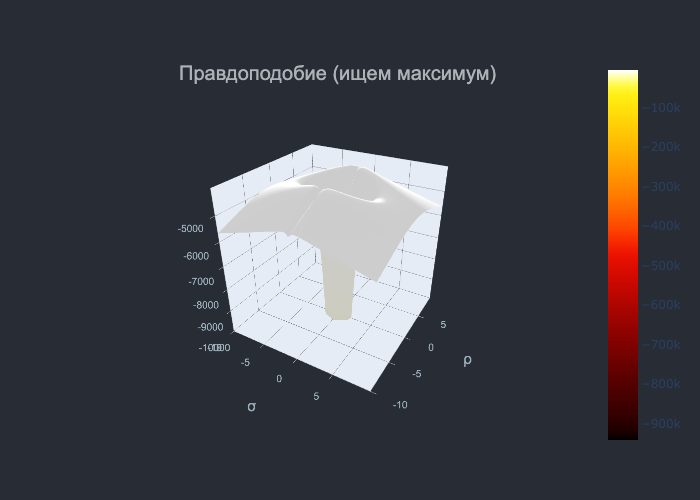

In [114]:
using Plots

plot(
    -10:0.3:10,
    -10:0.3:10,
    (σ, ρ) -> log_likelihood_times2(σ, ρ, z),
    st = :surface,
    zlims = (-1e4, Inf),
    title = "Правдоподобие (ищем максимум)",
    xlabel = "σ",
    ylabel = "ρ",
)

In [123]:
using Optim

res = optimize(
    p -> -log_likelihood_times2(p[1], p[2], z),
    [initial_guess, initial_guess],
    Newton(),            # Метод Ньютона — второй порядок
    autodiff = :forward, # Автоматическое дифференцирование с помощью ForwardDiff.jl
)

 * Status: success

 * Candidate solution
    Final objective value:     4.016496e+03

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.27e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    17
    f(x) calls:    107
    ∇f(x) calls:   107
    ∇²f(x) calls:  17


In [124]:
res.minimizer

2-element Vector{Float64}:
 -0.836210037287761
  4.08598470533134